# Compute CIS background model

In this notebook, we will compute the RNA travel length distribution to use in the CIS contact rate modeling. We are going to block out any mRNA that has been identified as broad binder according to the sample we're considering. 

## Generate .COOcounts file recording travel distance for each RNA

Similar to what we did in the data preparation for chartools, we prepare here an intermediate file containing the RNA travel distance indexed by RNA, then ingest it into a `chartable` object. This will allow us to examine the distribution of travel distance for different types of RNAs (exons vs introns) and to compute the cis background model. 

For that, we first prepare a simplified .pairs file (we could have started from .dna.bed.gz but did not for historical reasons).

First make a simplified pairs file, which contains filtered contact coordinates. 

In [ ]:
%%bash

function make_simple_pair {
export_LC_ALL="C"
input_folder="$1"

cd "$input_folder"

chartools pairup_simple paired.rna.bam paired.dna.bam rd.simple.pairs /oak/stanford/groups/astraigh/charseq2.0/genomes/hsapiens/grch38_foralign/resources/chrNameLength_1-22X.txt --qrna 255 --qdna 15
}

export -f make_simple_pair


#for ES, DE rep1
parallel -j6 -t --dry-run 'make_simple_pair /scratch/users/climouse/charseq2.0/libraries/{1}/data/{2}/pairs/gencondeV29_hg38/{3}' ::: novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun :::+ TFONM2_ES TGNQ5_DE ::: exons introns

#for ES, DE rep2
parallel -j6 -t --dry-run 'make_simple_pair /scratch/users/climouse/charseq2.0/libraries/{1}/data/{2}/pairs/gencondeV29_hg38/{3}' ::: novchar2/CL_2020-05-06_rerun ::: TMF2_Rep2B_ES TMF3_Rep2A_DE ::: exons introns

Now make a COO file `fly.COOcounts.tsv` has chr, flight_len, RNA, start_pos. A separate file is generated for RNAs mapping to exons and RNAs mapping to introns.

In [ ]:
%%bash

# chr, travel distance, RNA, start_pos
function make_COOfile {
export_LC_ALL="C"
input_file="$1"


cd $(dirname $input_file)
mkdir -p ./analysis/01_flight

awk -F $'\t' 'BEGIN{OFS=FS}($9==1){print $1, $10, $5, $2}' $input_file | sort -k3,3 -k1,1 -k2,2n >./analysis/01_flight/fly.COOcounts.tsv
}

export -f make_COOfile


parallel -j6 -t 'make_COOfile /scratch/users/climouse/charseq2.0/libraries/{1}/data/{2}/pairs/gencondeV29_hg38/{3}/rd.simple.pairs' ::: novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun :::+ TFONM2_ES TGNQ5_DE ::: exons introns

parallel -j6 -t 'make_COOfile /scratch/users/climouse/charseq2.0/libraries/{1}/data/{2}/pairs/gencondeV29_hg38/{3}/rd.simple.pairs' ::: novchar2/CL_2020-05-06_rerun :::TMF2_Rep2B_ES TMF3_Rep2A_DE ::: exons introns

## Ingest travel distance data into a `chartable` object for handling in python with `chartools`

Load modules

In [19]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from importlib import reload

import matplotlib as mpl
from scipy import sparse as sp

import pickle

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 16
mpl.rcParams['figure.titlesize'] = 14
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from chartools import charcounter as cc
import pickle

Define samples to process

In [20]:
data_root='/oak/stanford/groups/astraigh/differentiation_paper_data/charles/libraries'
NOVA1="novchar1/NOVAseq_06-27-2019/CL_2020-05-06_rerun/data"
NOVA2="novchar2/CL_2020-05-06_rerun/data"

NOVA1_smpls=['TFONM2_ES','TGNQ5_DE']
NOVA2_smpls=['TMF2_Rep2B_ES','TMF3_Rep2A_DE']
libs={}
for k in NOVA1_smpls:
    libs[k]=os.path.join(data_root,NOVA1, k)
for k in NOVA2_smpls:
    libs[k]=os.path.join(data_root,NOVA2, k)

Load gene definitions

In [21]:
genes=pd.read_csv('/oak/stanford/groups/astraigh/charseq2.0/genomes/hsapiens/grch38_foralign/ENSG_1_X.csv', index_col=0)

chr_df=pd.read_csv('/oak/stanford/groups/astraigh/charseq2.0/genomes/hsapiens/grch38_foralign/resources/chrNameLength_1-22X.txt', names=['chr','len'], sep='\t', index_col=0)

gene_strand_dict={k: (True if v=="-" else False) for k, v in genes.strand.to_dict().items()}


chr_list=list(chr_df.index)
chr_list.sort()
chr_to_chrid={v:i for i,v in enumerate(chr_list)}

gene_to_chrid=genes['chr'].map(chr_to_chrid).to_dict()

for k, v in gene_to_chrid.items():
    gene_to_chrid[k]=[v,v]
    
gene_to_id={k:[i,gene_to_chrid[k][0]] for i, k in enumerate(list(genes.index))}

chr_LUT=[""]*len(chr_to_chrid)
for k, v in chr_to_chrid.items():
    chr_LUT[v]=k
    
chr_len_vec=chr_df.reindex(chr_LUT).values.flatten()

Ingest the travel distance data into a chartable object and pickle it, for each sample and for exons and introns separately

In [ ]:
smpls=NOVA1_smpls + NOVA2_smpls 
annot_type=['exons','introns']
bins_plus=np.unique((np.floor(np.logspace(0,np.log10(25000000),500))*10).astype(int))
bins=np.hstack([-np.flip(bins_plus),0,bins_plus])
    
for s in smpls:
    for t in annot_type:
        print("%s_%s"%(s,t))

        datafile=os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/fly.COOcounts.tsv'%t)
        outfile=os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/fly.stranded.pickle'%t)

        t0_stranded=cc.Chartable(file_bed=None, chr_dict=chr_to_chrid, annot_chr_dict=gene_to_id, chr_len_vec=chr_len_vec, bins_name_col=-1)

        inaccessible_flight_stranded= t0_stranded.load_fly_table(datafile, bins=bins, reorganize_genes=False, gene_strand_dict=gene_strand_dict)


        fly_stranded={'bins':bins, 'file':datafile, 'inaccessible_flight':inaccessible_flight_stranded, 'data':t0_stranded}
        with open(outfile, 'wb') as output:
            pickle.dump(fly_stranded, output, pickle.HIGHEST_PROTOCOL)

## Compute CIS travel distance models

Here, we will aggregate over all mRNAs the profile of their source-target "travel" distance, to generate a model for RNA travel used in the generative model for ChAR-seq contact map predictions (see paper).  

### Mask out trans-delocalized RNAs from CIS model

We need to exclude RNAs that have been identified as trans delocalized from this aggregation, as they have a qualitatively distinct behavior. 

In [22]:
#load delocalization score. NOTE: we used here an older computation of trans-localization scores, which is different from the one used in the delocalization scores section of the paper. This is for historical reason and doesn not affect the outcome of the analysis.
bb=pd.read_csv('/home/groups/astraigh/differentiation_charseq_paper/notebooks/charles/02_broadBinders/data/tscores_cep002bb.csv')
bb=bb.set_index('ENSN')

#remove RNAs with significant delocalization scores in any of the for samples
bb_significant=bb.loc[(bb['p.high.corr_ES1']<0.05) | (bb['p.high.corr_ES2']<0.05) | (bb['p.high.corr_DE1']<0.05) | (bb['p.high.corr_DE2']<0.05)]

#only include mRNAs
bb_signficant_mRNA=bb_significant.loc[bb_significant['type']=='protein_coding']
mRNAs_to_remove_for_bkg=bb_signficant_mRNA.index.to_list()

rnas_towards_background=[k for k in genes.loc[genes.type=='protein_coding'].index.to_list() if k not in mRNAs_to_remove_for_bkg]

#show the list of rnas used for modeling the CIS contacts.
bgk_mrnas_df=genes.reindex(rnas_towards_background)
bgk_mrnas_df.head()



,type,name,chr,strand,L
ENSG,,,,,
ENSG00000186092.6,protein_coding,OR4F5,chr1,+,6166
ENSG00000284733.1,protein_coding,OR4F29,chr1,-,994
ENSG00000284662.1,protein_coding,OR4F16,chr1,-,994
ENSG00000187634.11,protein_coding,SAMD11,chr1,+,20653
ENSG00000188976.10,protein_coding,NOC2L,chr1,-,15105


### Core functions for aggregating travel distance distribution across relevant mRNAs

In [23]:
def normalize_fly_profile(p, p_inaccessible, bins):
    x=p/np.maximum(1,p.sum()-p_inaccessible)
    
    x_raw=x
    
    # add that
    x_raw[0]=0
    x_raw[-1]=0
    #
    
    x_raw=x_raw/x_raw.sum()
    
    x=x[1:-1]
    x=x/x.sum()
    d=np.diff(bins)
    x=x/d
    xn=x/x.sum()
    
    bins_centers=(bins[0:-1]+bins[1:])/2
    nb=len(bins_centers)

    nn=int(nb/2)
    
    sym=(xn[nn:]+np.flip(xn[0:nn]))/2
    asym=((xn[nn:]-np.flip(xn[0:nn]))/2)/sym
    
    xn_symmetrized=np.hstack([np.flip(sym),sym])
    
    sym_raw=(x_raw[(nn+1):]+np.flip(x_raw[0:(nn+1)]))/2
    x_raw_symmetrized=np.hstack([np.flip(sym_raw),sym_raw])
    
    return xn, xn_symmetrized, asym, bins_centers, x_raw, x_raw_symmetrized


def make_fly_profile_bychr(fly_stranded, bgk_mrnas):

    profiles_bychr={'xn':[], 'xn_symmetrized':[], 'asym':[], 'xraw':[],  'xraw_symmetrized':[]}
    
    bins=fly_stranded['bins']
    profiles_bychr['bins']=bins
    fly_bkg_all=np.zeros(len(bins)+1)
    inaccessible_bkg_all=np.zeros(len(bins)+1)
    
    for i, k in enumerate(fly_stranded['data'].chr_LUT):
        
        these_mrnas=bgk_mrnas.loc[bgk_mrnas.chr==k].index.to_list()
        
        fly_bkg=np.array(fly_stranded['data'].select_annots(these_mrnas).counts.sum(axis=0)).ravel()
        
        inaccessible_bkg= np.array(fly_stranded['inaccessible_flight'].select_annots(these_mrnas).counts.sum(axis=0)).ravel()
        
        fly_bkg_all+=fly_bkg
        inaccessible_bkg_all+=inaccessible_bkg
        

        xn, xn_symmetrized, asym, tmp, x_raw, x_raw_symmetrized = normalize_fly_profile(fly_bkg, inaccessible_bkg, bins)
        profiles_bychr['xn']=profiles_bychr['xn']+[xn]
        profiles_bychr['xn_symmetrized']=profiles_bychr['xn_symmetrized']+[xn_symmetrized]
        profiles_bychr['asym']=profiles_bychr['asym']+[asym]
        profiles_bychr['xraw']=profiles_bychr['xraw']+[x_raw]
        profiles_bychr['xraw_symmetrized']=profiles_bychr['xraw_symmetrized']+[x_raw_symmetrized]

    xn, xn_symmetrized, asym, tmp, x_raw, x_raw_symmetrized = normalize_fly_profile(fly_bkg_all, inaccessible_bkg_all, bins)
    profiles_allchr={'xn':xn, 'xn_symmetrized':xn_symmetrized, 'asym':asym, 'xraw':x_raw, 'xraw_symmetrized':x_raw_symmetrized, 'bins':bins}
    
    return profiles_bychr, profiles_allchr

def make_cismodel(profiles_bychr, use_symmetric=False):
    profile_cum_bychr=[]
    rho_by_chr=[]

    d=np.diff(profiles_bychr['bins'])
    v='xraw'
    if use_symmetric:
        v='xraw_symmetrized'
    for p in profiles_bychr[v]:
        profile_cum=p.cumsum()
        profile_cum=profile_cum/profile_cum[-1]
        profile_cum_bychr+=[profile_cum]

        rho=p[1:-1]/d
        rho_by_chr+=[np.hstack([0, rho, 0])]


    cismodel={'bins':profiles_bychr['bins'], 'chi':profile_cum_bychr, 'rho':rho_by_chr, 'dchi':profiles_bychr[v]}
    
    return cismodel

### Run the computation

In [24]:
smpls= NOVA1_smpls + NOVA2_smpls
annot_type=['exons','introns']
infodf=[bgk_mrnas_df, bgk_mrnas_df]

cisprofiles_bychr={}
cisprofiles_allchr={}
cismodel={}
for s in smpls:
    for i, t in enumerate(annot_type):
        ix="%s_%s"%(s,t)
        
        fly_stranded=pickle.load( open(os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/fly.stranded.pickle'%t), "rb" ) )
        
        outfile_profiles=os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/cisprofiles.pickle'%t)
        outfile_cismodels=os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/cismodel.pickle'%t)
        
        profiles_bychr, profiles_allchr=make_fly_profile_bychr(fly_stranded, infodf[i])
        this_cismodel=make_cismodel(profiles_bychr)
        cisprofiles_bychr[ix]=profiles_bychr
        cisprofiles_allchr[ix]=profiles_allchr
        cismodel[ix]=this_cismodel
        
        with open(outfile_profiles, 'wb') as output:
            pickle.dump({'cisprofiles_allchr':profiles_allchr,'cisprofiles_bychr':profiles_bychr}, output, pickle.HIGHEST_PROTOCOL)
            
        with open(outfile_cismodels, 'wb') as output:
            pickle.dump(this_cismodel, output, pickle.HIGHEST_PROTOCOL)

/share/software/user/open/py-jupyter/1.0.0_py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


## Display the resulting RNA travel distance profiles

In [25]:
%matplotlib inline

First plot the profiles within 1kb of source

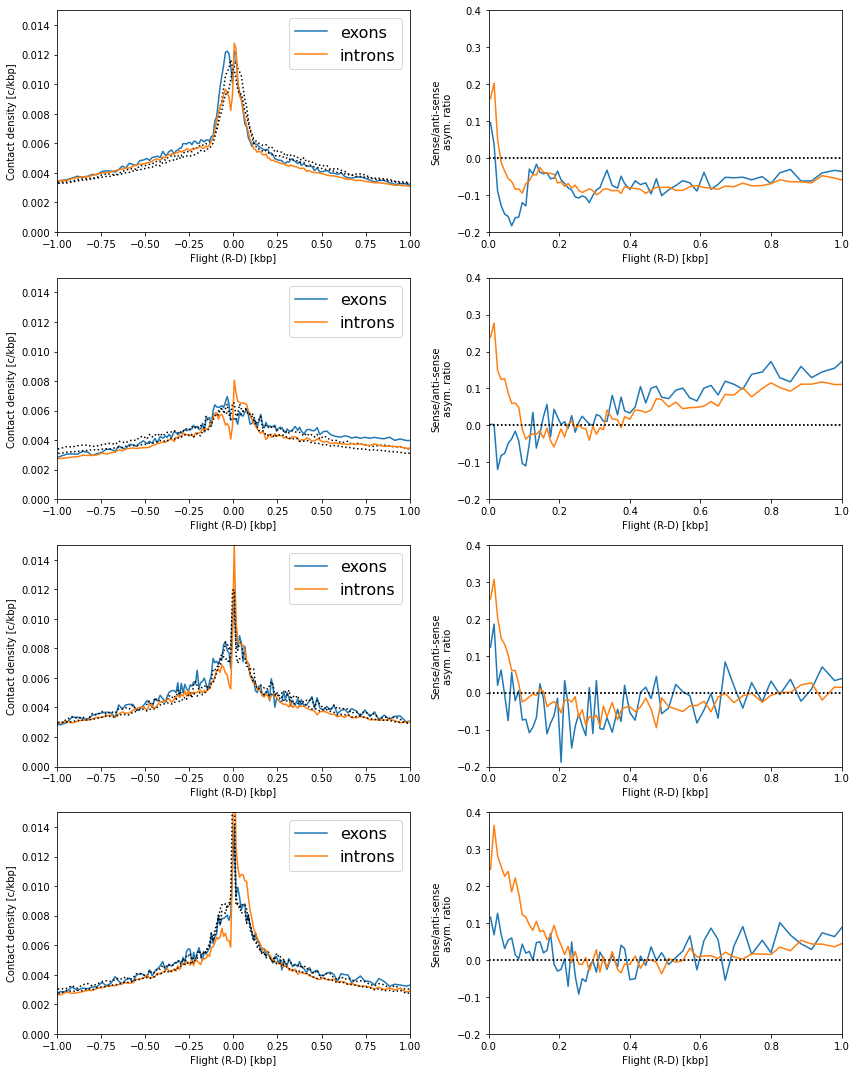

In [26]:
bins_plus=np.unique((np.floor(np.logspace(0,np.log10(25000000),500))*10).astype(int))
bins=np.hstack([-np.flip(bins_plus),0,bins_plus])

bins_centers=(bins[0:-1]+bins[1:])/2
nb=len(bins_centers)
nn=int(nb/2)
binsP=bins_centers[nn:]

fig, axs = plt.subplots(4, 2, figsize=(12, 15))

for i, s in enumerate(NOVA1_smpls + NOVA2_smpls):
    for t in ['exons','introns']:
#         ix="%s_%s"%(s,t)
        these_profiles=pickle.load(open(os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/cisprofiles_test.pickle'%t),'rb'))
        profiles_allchr=these_profiles['cisprofiles_allchr']
        
            
        axs[i,0].plot(bins_centers/1000, profiles_allchr['xn'], label=t)
        axs[i,0].plot(bins_centers/1000,  profiles_allchr['xn_symmetrized'], color='k', linestyle=':')

        axs[i,0].set_xlim([-1,1])
        axs[i,0].set_ylim([0,0.015])
        axs[i,1].plot(binsP/1000, profiles_allchr['asym'])
        axs[i,1].set_xlim([0,1])
        axs[i,1].set_ylim([-0.2,0.4])
        axs[i,1].axhline([0], color='k', linestyle=':')
        axs[i,0].legend()
        axs[i,0].set_xlabel('Flight (R-D) [kbp]')
        axs[i,0].set_ylabel('Contact density [c/kbp]')
        
        axs[i,1].set_xlabel('Flight (R-D) [kbp]')
        axs[i,1].set_ylabel('Sense/anti-sense\nasym. ratio')
        
plt.tight_layout()

Now plot the profile over 10kb within source

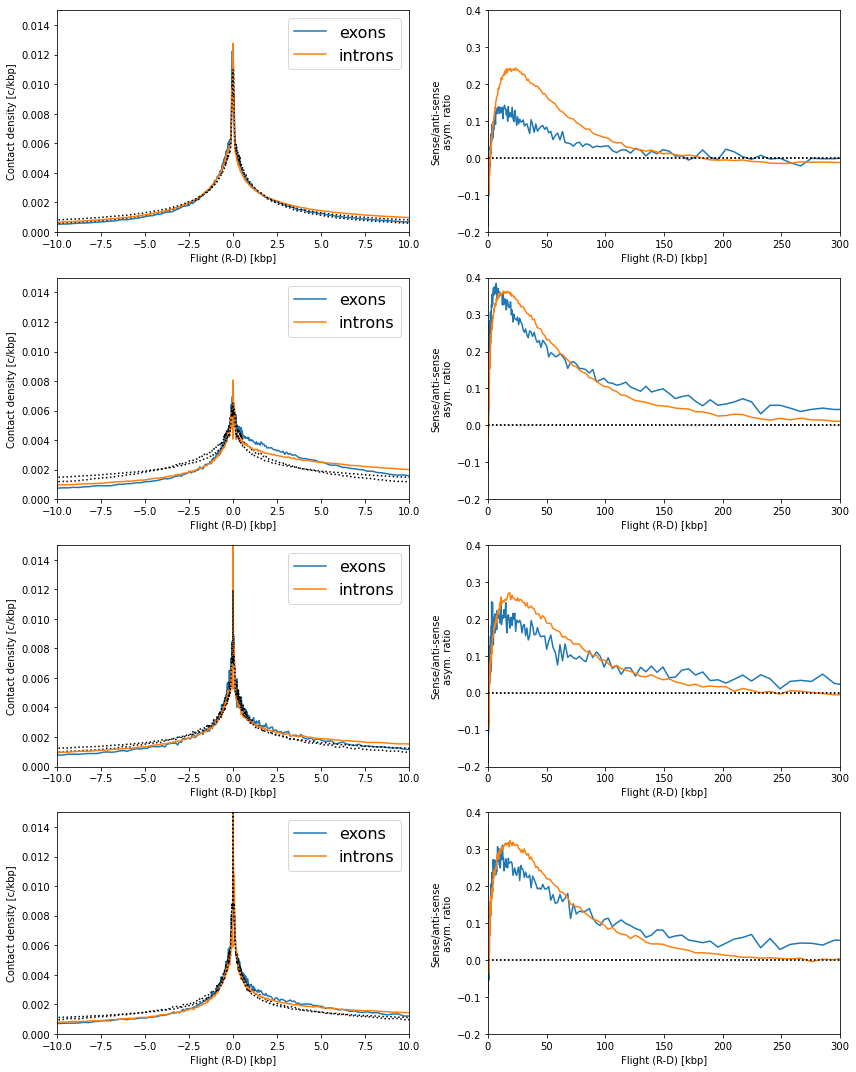

In [27]:
bins_centers=(bins[0:-1]+bins[1:])/2
nb=len(bins_centers)
nn=int(nb/2)
binsP=bins_centers[nn:]

fig, axs = plt.subplots(4, 2, figsize=(12, 15))

for i, s in enumerate(NOVA1_smpls + NOVA2_smpls):
    for t in ['exons','introns']:
#         ix="%s_%s"%(s,t)
        these_profiles=pickle.load(open(os.path.join(libs[s],'pairs/gencondeV29_hg38/%s/analysis/01_flight/cisprofiles.pickle'%t),'rb'))
        profiles_allchr=these_profiles['cisprofiles_allchr']
        
            
        axs[i,0].plot(bins_centers/1000, profiles_allchr['xn'], label=t)
        axs[i,0].plot(bins_centers/1000,  profiles_allchr['xn_symmetrized'], color='k', linestyle=':')

        axs[i,0].set_xlim([-10,10])
        axs[i,0].set_ylim([0,0.015])
        axs[i,1].plot(binsP/1000, profiles_allchr['asym'])
        axs[i,1].set_xlim([0,300])
        axs[i,1].set_ylim([-0.2,0.4])
        axs[i,1].axhline([0], color='k', linestyle=':')
        axs[i,0].legend()
        axs[i,0].set_xlabel('Flight (R-D) [kbp]')
        axs[i,0].set_ylabel('Contact density [c/kbp]')
        
        axs[i,1].set_xlabel('Flight (R-D) [kbp]')
        axs[i,1].set_ylabel('Sense/anti-sense\nasym. ratio')
        
plt.tight_layout()